In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import math
import json

from matplotlib.ticker import MultipleLocator

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.utils import ImageReader

from stream_analysis.env_ import Env_
from stream_analysis.chat import Chat
from stream_analysis.summary import Summary

%matplotlib inline

In [2]:
def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'


def logging_watching_url(output_path, url, time, file_name: str = 'watching_urls.log'):
    path = os.path.join(output_path, file_name)
    with open(path, 'a', encoding='utf8') as f:
        f.write(url + f'?t={time}\n')


def get_word_freq(array):
    text_vectorizer = CountVectorizer(stop_words='english', encoding='utf8')
    X = text_vectorizer.fit_transform(array)
    word_freq = pd.DataFrame(
        X.toarray(), columns=text_vectorizer.get_feature_names_out())
    word_freq = word_freq.sum().sort_values(ascending=False)
    return word_freq


def draw_markdown_to_pdf(canvas, text, cursor, margin, width, height, font_name):
    # 轉換 Markdown 到純文本
    paragraphs = text.split('\n')

    canvas.setFont(font_name, 8)
    for paragraph in paragraphs:
        lines = paragraph.split('\n')
        for line in lines:
            # 計算每一行文本的寬度並進行多行處理
            if cursor < 50:  # 確保不超出頁面底部
                canvas.showPage()
                cursor = height - 50
            text_width = canvas.stringWidth(line, font_name, 12)
            if text_width > width:
                # 如果行寬超出可用寬度，進行換行處理
                words = line.split(' ')
                current_line = ""
                for word in words:
                    if canvas.stringWidth(current_line + word, font_name, 12) > width:
                        canvas.drawString(margin, cursor, current_line.strip())
                        cursor -= 15
                        current_line = word + ' '
                    else:
                        current_line += word + ' '
                if current_line:
                    canvas.drawString(margin, cursor, current_line.strip())
                    cursor -= 15
            else:
                canvas.drawString(margin, cursor, line.strip())
                cursor -= 15
    return cursor

In [3]:
env_ = Env_(video_live_url='https://www.youtube.com/live/evcruocvE3g?si=kAljJVjWx9aYaFsBclea')

with open(env_.video_data_path, 'w', encoding='utf8') as f:
    json.dump(env_.video_data, f, indent=2, ensure_ascii=False)

In [4]:
chat = Chat(env_)
df = chat.get()
df.to_csv(env_.chat_csv_path, index=False)

In [5]:
df.head()

,author_id,author_name,author_title,author_membership_duration,author_badge,author_image,message,message_without_emotes,cleaned_message,message_type,money,time_in_seconds,timestamp,time_in_minutes
2,UCVUWCmCfMIe38OxINPhQLcA,MysticMark - Deputy Deadbeat,,0,,https://yt4.ggpht.com/QDMQuourCXXazcipnVISFnfO...,:face-red-heart-shape::face-red-heart-shape::f...,,,text_message,0.0,0.000,1725751834073915,0
0,UCcoG55HnyakF7jg2AUPXkDQ,SpanKFPenheim,member,1095,https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...,https://yt4.ggpht.com/EzPpkWgpGnX7ETc_T6RIcH-S...,Gifted 10 Mori Calliope Ch. hololive-EN member...,Gifted 10 Mori Calliope Ch. hololive-EN member...,Gifted 10 Mori Calliope Ch hololiveEN memberships,sponsorships_gift_purchase_announcement,0.0,0.000,1725751351838104,0
1,UCo5ms10qwk6lj-GahufSR8w,Zenzoze,,0,,https://yt4.ggpht.com/7-53A0AHxE9MtiVrWWzR7IRN...,:face-red-heart-shape::face-red-heart-shape::f...,,,text_message,0.0,0.000,1725751833970231,0
3,UCRlKp8Z8dHpfsYB-fbsIAEg,Ran Bindoy,member,365,https://yt3.ggpht.com/F0YU4PUesWXUyOENvw51yhHC...,https://yt4.ggpht.com/ytc/AIdro_muInEf7j4pqB5a...,:_canteloupe:,,,text_message,0.0,1.186,1725751837541672,0
4,UC6TGisS9qkdkbGnXygTG6sA,Ghost Sapling,member,365,https://yt3.ggpht.com/F0YU4PUesWXUyOENvw51yhHC...,https://yt4.ggpht.com/dmQtzszCMbvtC0HSi_K9FxJy...,:_canteloupe::_canteloupe::_canteloupe:,,,text_message,0.0,1.649,1725751838012551,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19888 entries, 2 to 887
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   author_id                   19888 non-null  object 
 1   author_name                 19888 non-null  object 
 2   author_title                19888 non-null  object 
 3   author_membership_duration  19888 non-null  int64  
 4   author_badge                19888 non-null  object 
 5   author_image                19888 non-null  object 
 6   message                     19888 non-null  object 
 7   message_without_emotes      19888 non-null  object 
 8   cleaned_message             19888 non-null  object 
 9   message_type                19888 non-null  object 
 10  money                       19888 non-null  float64
 11  time_in_seconds             19888 non-null  float64
 12  timestamp                   19888 non-null  int64  
 13  time_in_minutes             19888 non-

In [7]:
df['message'].nunique()

12608

In [8]:
df['message_without_emotes'].nunique()

11674

In [9]:
df['cleaned_message'].nunique()

9931

In [10]:
df_per_minute = df.copy(True)
df_per_minute.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19888 entries, 2 to 887
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   author_id                   19888 non-null  object 
 1   author_name                 19888 non-null  object 
 2   author_title                19888 non-null  object 
 3   author_membership_duration  19888 non-null  int64  
 4   author_badge                19888 non-null  object 
 5   author_image                19888 non-null  object 
 6   message                     19888 non-null  object 
 7   message_without_emotes      19888 non-null  object 
 8   cleaned_message             19888 non-null  object 
 9   message_type                19888 non-null  object 
 10  money                       19888 non-null  float64
 11  time_in_seconds             19888 non-null  float64
 12  timestamp                   19888 non-null  int64  
 13  time_in_minutes             19888 non-

In [11]:
df_per_minute.head()

,author_id,author_name,author_title,author_membership_duration,author_badge,author_image,message,message_without_emotes,cleaned_message,message_type,money,time_in_seconds,timestamp,time_in_minutes
2,UCVUWCmCfMIe38OxINPhQLcA,MysticMark - Deputy Deadbeat,,0,,https://yt4.ggpht.com/QDMQuourCXXazcipnVISFnfO...,:face-red-heart-shape::face-red-heart-shape::f...,,,text_message,0.0,0.000,1725751834073915,0
0,UCcoG55HnyakF7jg2AUPXkDQ,SpanKFPenheim,member,1095,https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...,https://yt4.ggpht.com/EzPpkWgpGnX7ETc_T6RIcH-S...,Gifted 10 Mori Calliope Ch. hololive-EN member...,Gifted 10 Mori Calliope Ch. hololive-EN member...,Gifted 10 Mori Calliope Ch hololiveEN memberships,sponsorships_gift_purchase_announcement,0.0,0.000,1725751351838104,0
1,UCo5ms10qwk6lj-GahufSR8w,Zenzoze,,0,,https://yt4.ggpht.com/7-53A0AHxE9MtiVrWWzR7IRN...,:face-red-heart-shape::face-red-heart-shape::f...,,,text_message,0.0,0.000,1725751833970231,0
3,UCRlKp8Z8dHpfsYB-fbsIAEg,Ran Bindoy,member,365,https://yt3.ggpht.com/F0YU4PUesWXUyOENvw51yhHC...,https://yt4.ggpht.com/ytc/AIdro_muInEf7j4pqB5a...,:_canteloupe:,,,text_message,0.0,1.186,1725751837541672,0
4,UC6TGisS9qkdkbGnXygTG6sA,Ghost Sapling,member,365,https://yt3.ggpht.com/F0YU4PUesWXUyOENvw51yhHC...,https://yt4.ggpht.com/dmQtzszCMbvtC0HSi_K9FxJy...,:_canteloupe::_canteloupe::_canteloupe:,,,text_message,0.0,1.649,1725751838012551,0


In [12]:
time_labels = pd.to_datetime(df_per_minute['time_in_minutes'], unit='m').dt.strftime('%H:%M').unique()

time_labels_10min = time_labels[::10]
minutes_10min = df_per_minute['time_in_minutes'].unique()[::10]

display(time_labels_10min)
minutes_10min

array(['00:00', '00:10', '00:20', '00:30', '00:40', '00:50', '01:00',
       '01:10', '01:20', '01:30', '01:40', '01:50', '02:00', '02:10',
       '02:20', '02:30', '02:40', '02:50', '03:00', '03:10', '03:20',
       '03:30', '03:40', '03:50', '04:00', '04:10', '04:20'], dtype=object)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260])

In [13]:
df_numeric_per_minute = df_per_minute.groupby('time_in_minutes').agg(
    author_membership_duration_avg=('author_membership_duration', 'mean'),
    money_sum=('money', 'sum')
).reset_index()
df_numeric_per_minute[['author_membership_duration_avg', 'money_sum']].describe()

,author_membership_duration_avg,money_sum
count,267.000000,267.000000
mean,419.300578,1.348314
std,82.940304,6.349866
min,121.333333,0.000000
25%,364.529178,0.000000
50%,423.163265,0.000000
75%,469.255952,0.000000
max,700.833333,73.662973


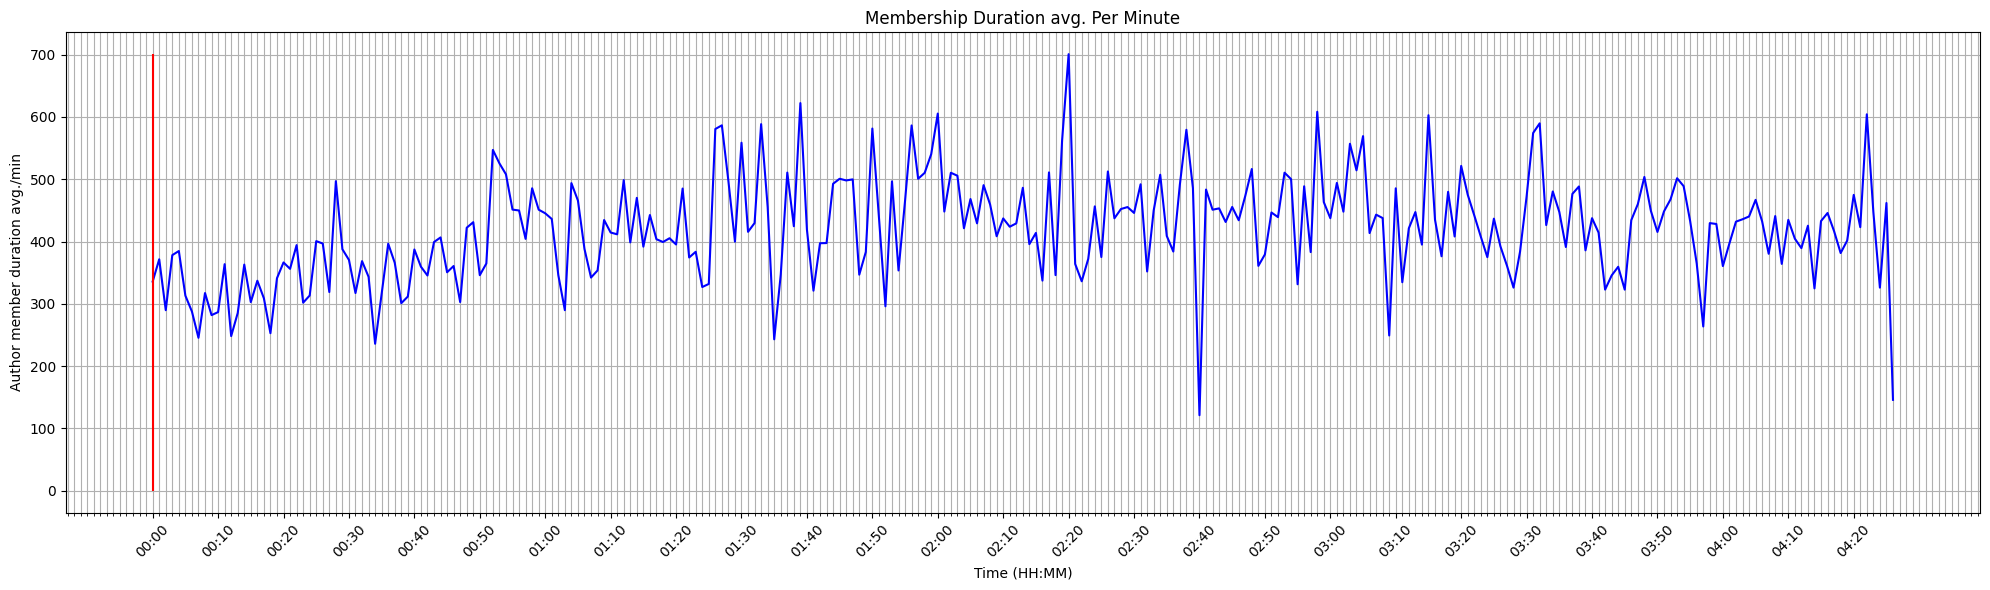

In [14]:
plt.figure(figsize=(20, 6))

plt.plot(df_numeric_per_minute['time_in_minutes'], df_numeric_per_minute['author_membership_duration_avg'], label='Membership Duration avg.', color='blue')

plt.vlines(0, ymin=0, ymax=df_numeric_per_minute['author_membership_duration_avg'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Author member duration avg./min')
plt.title('Membership Duration avg. Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.show()

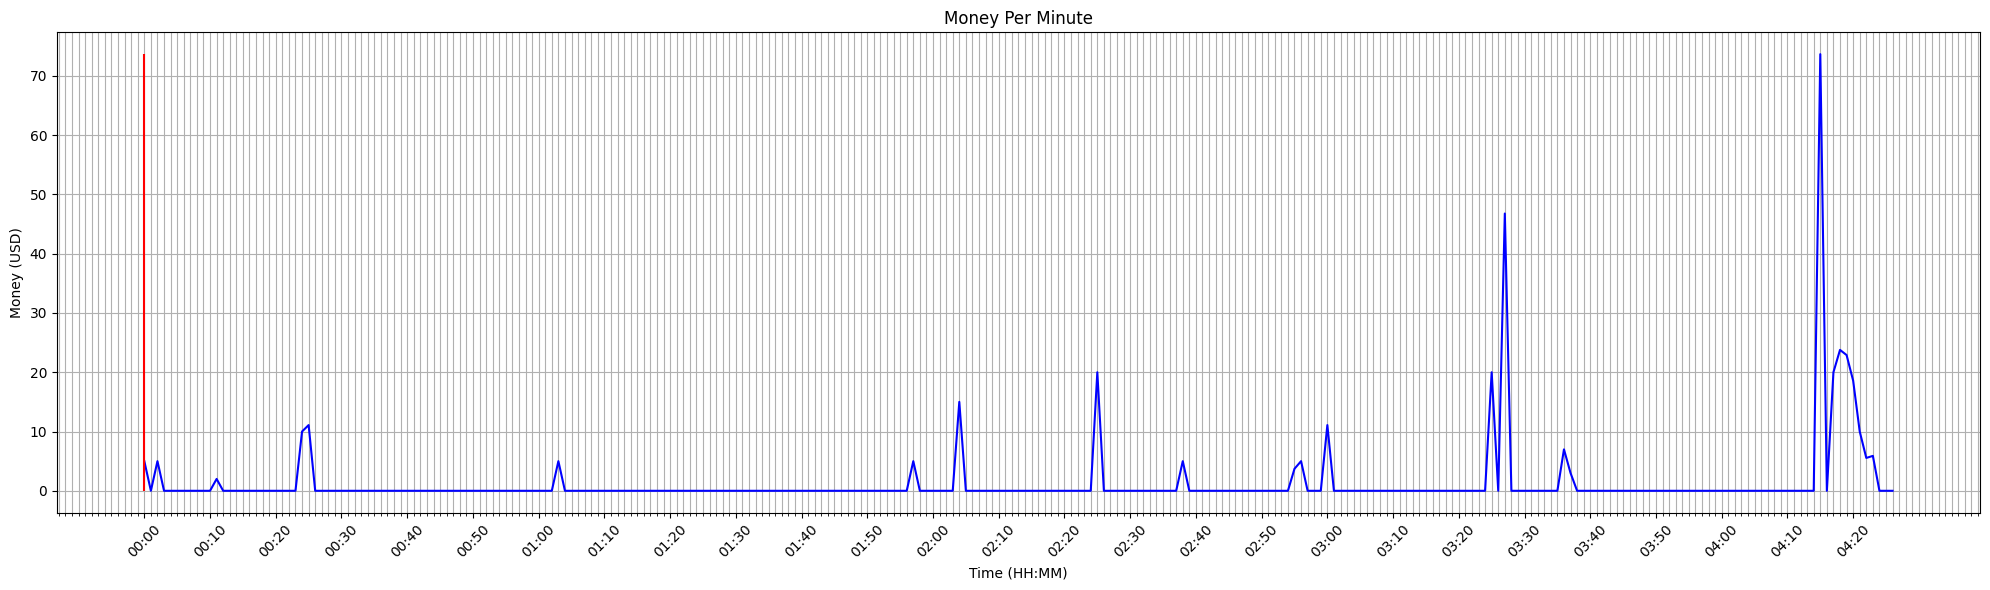

In [15]:
plt.figure(figsize=(20, 6))

plt.plot(df_numeric_per_minute['time_in_minutes'], df_numeric_per_minute['money_sum'], label='Money Per Minute', color='blue')

plt.vlines(0, ymin=0, ymax=df_numeric_per_minute['money_sum'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Money (USD)')
plt.title('Money Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [16]:
df_message_count = df_per_minute[df_per_minute['message'].str.len() > 0].groupby('time_in_minutes').agg(
    message_count=('message', 'count'),
).reset_index()
df_message_count[['message_count']].describe()

,message_count
count,267.000000
mean,74.426966
std,53.250625
min,10.000000
25%,39.000000
50%,61.000000
75%,90.000000
max,341.000000


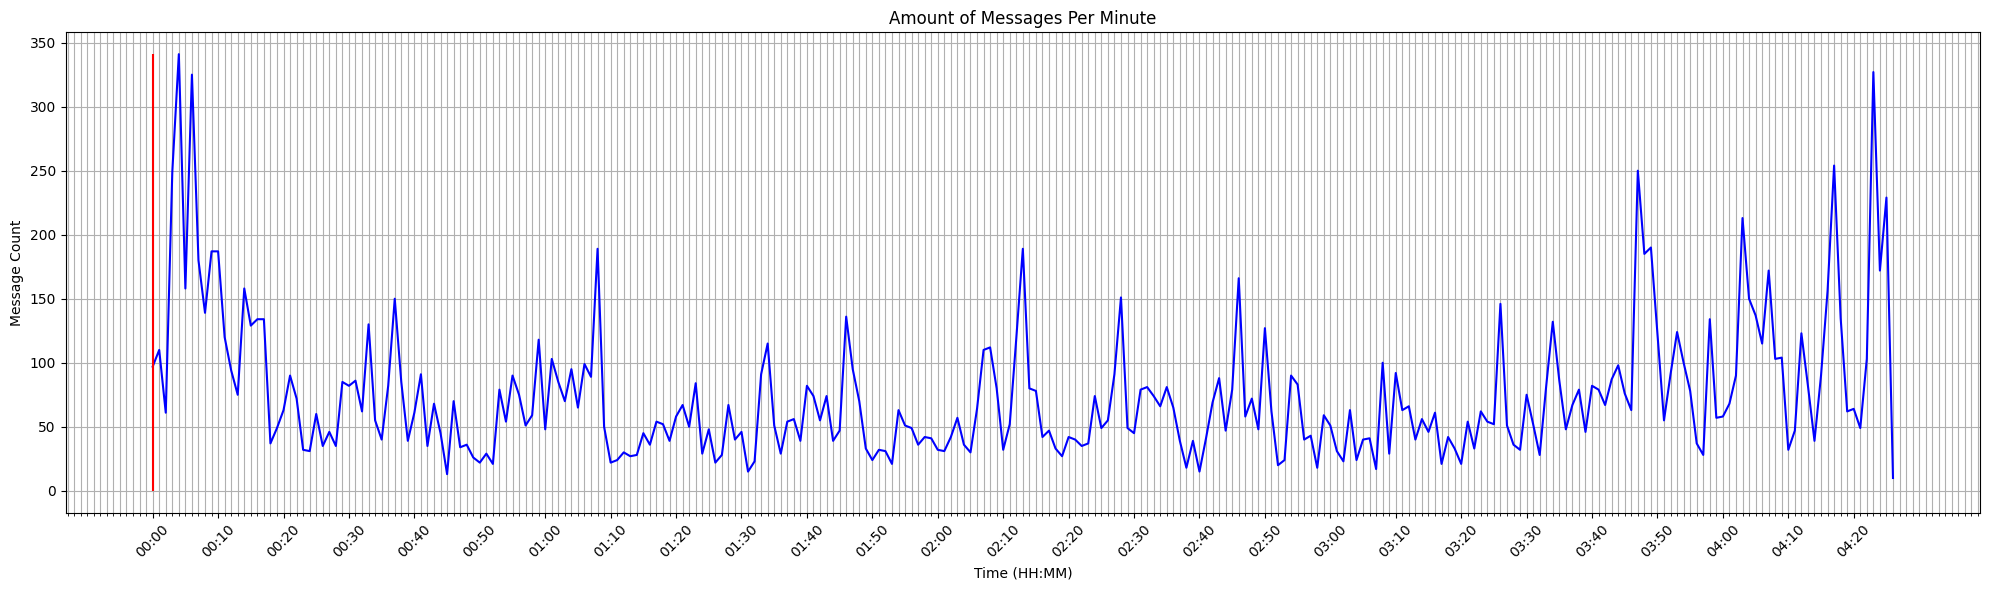

In [17]:
plt.figure(figsize=(20, 6))

plt.plot(df_message_count['time_in_minutes'], df_message_count['message_count'], label='Total Messages', color='blue')

plt.vlines(0, ymin=0, ymax=df_message_count['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Amount of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [18]:
df_message_without_emotes_count = df_per_minute[df_per_minute['message_without_emotes'].str.len() > 0].groupby('time_in_minutes').agg(
    message_count=('message_without_emotes', 'count'),
).reset_index()
df_message_without_emotes_count[['message_count']].describe()

,message_count
count,267.000000
mean,53.831461
std,36.763183
min,5.000000
25%,31.000000
50%,44.000000
75%,65.000000
max,270.000000


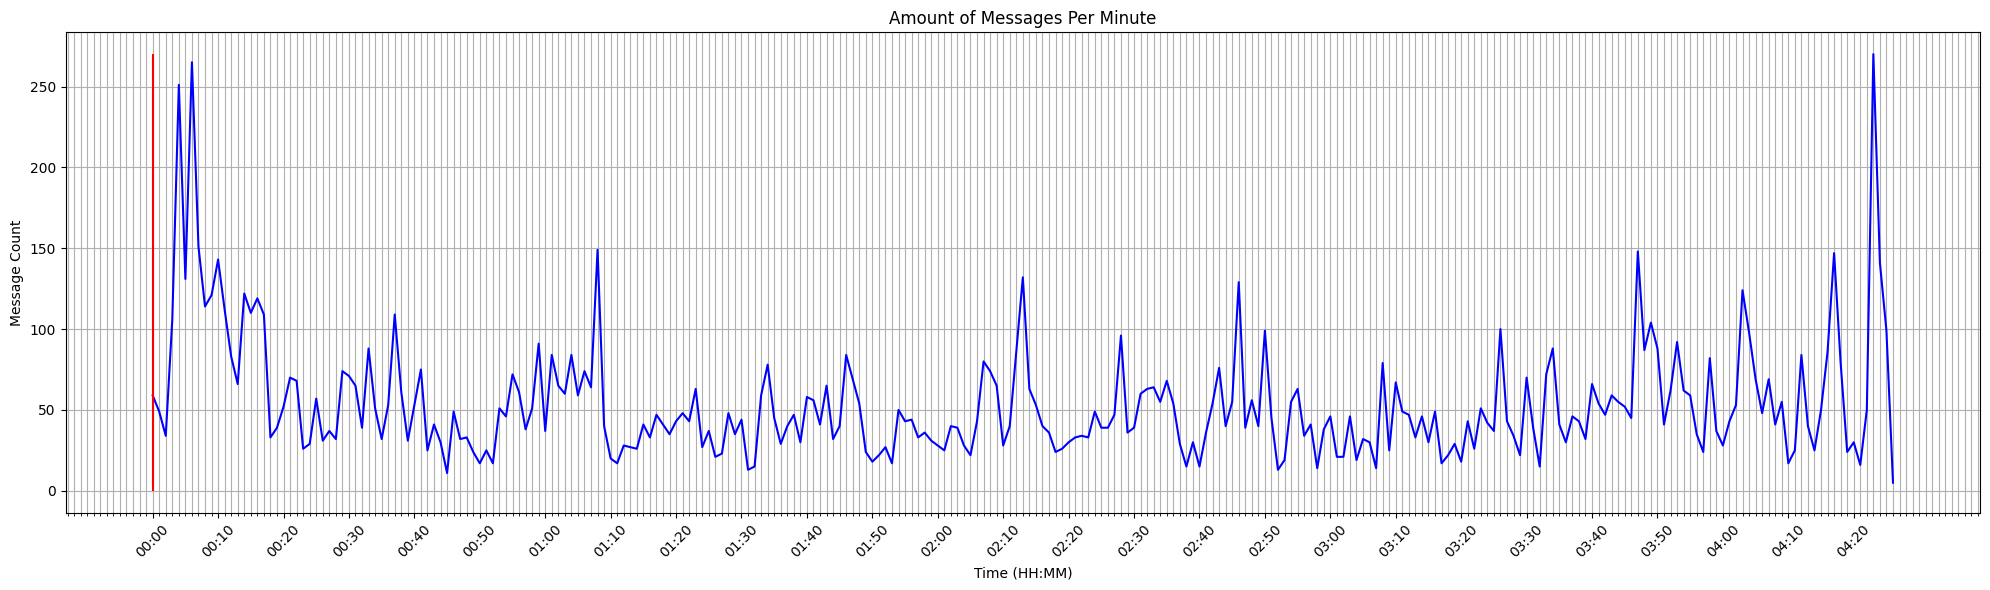

In [19]:
data = df_message_without_emotes_count[df_message_without_emotes_count['message_count'] > 0]
plt.figure(figsize=(20, 6))

plt.plot(data['time_in_minutes'], data['message_count'], label='Total Messages Without Emotes', color='blue')

plt.vlines(0, ymin=0, ymax=data['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Amount of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [20]:
df_cleaned_count = df_per_minute[df_per_minute['cleaned_message'].str.len() > 0].groupby('time_in_minutes').agg(
    message_count=('cleaned_message', 'count'),
).reset_index()
df_cleaned_count[['message_count']].describe()

,message_count
count,267.000000
mean,46.217228
std,32.547906
min,4.000000
25%,28.000000
50%,38.000000
75%,55.500000
max,264.000000


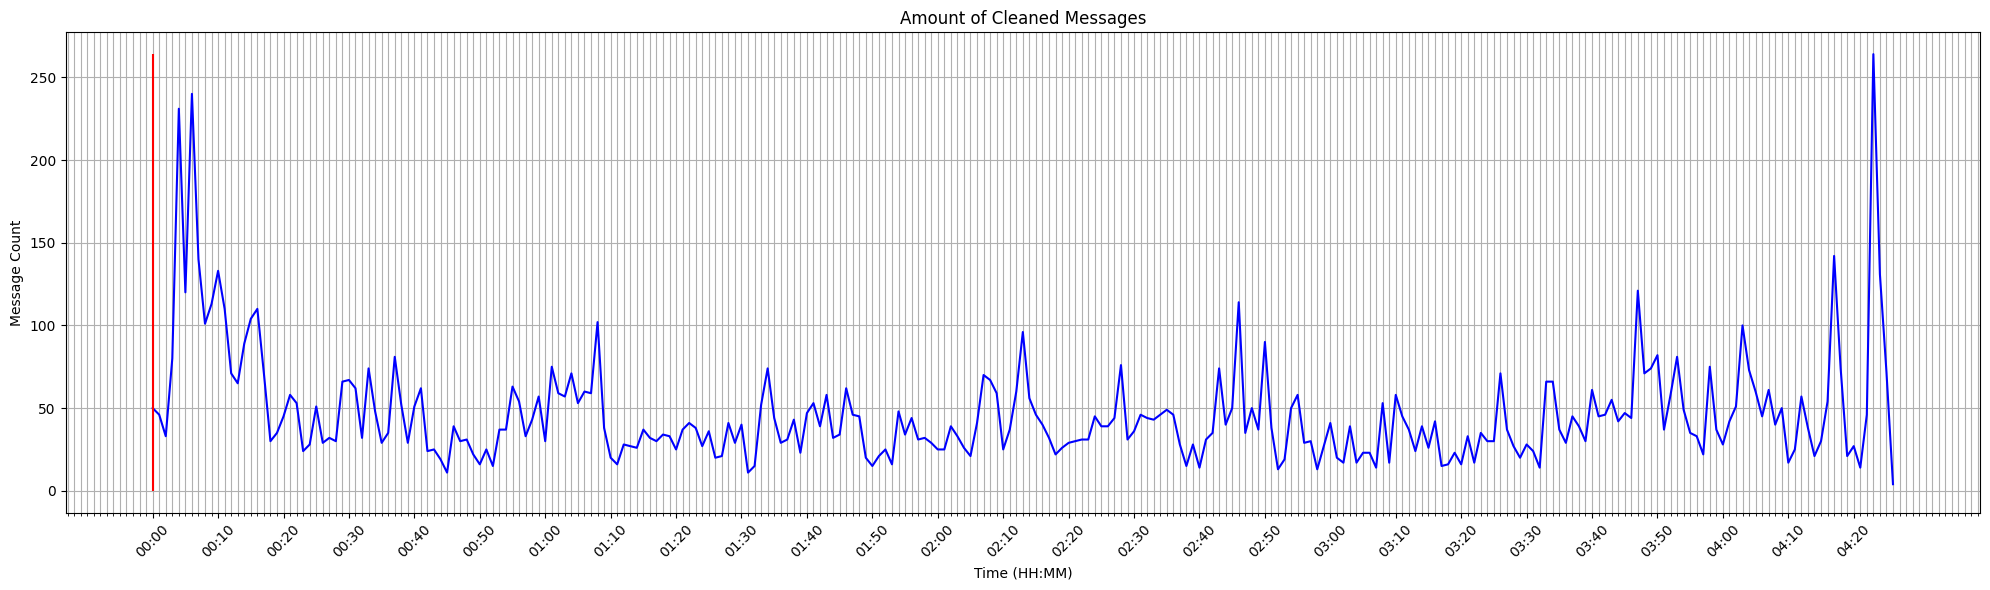

In [21]:
data = df_cleaned_count
plt.figure(figsize=(20, 6))

plt.plot(data['time_in_minutes'], data['message_count'], label='Total Cleaned Messages', color='blue')

plt.vlines(0, ymin=0, ymax=data['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Amount of Cleaned Messages')

plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [22]:
df_per_minute = df.copy(True)
df_per_minute['time_in_minutes'] = (df['time_in_seconds'] // 60).astype(int)

total_messages_per_minute = df_per_minute.groupby('time_in_minutes').size().reset_index(name='message_count')

member_messages_per_minute = df_per_minute[df_per_minute['author_title'] == 'member'].groupby('time_in_minutes').size().reset_index(name='message_count')

moeny_per_minute = df_per_minute.groupby('time_in_minutes').sum('amount')

moving_average = total_messages_per_minute.copy(True)
moving_average['message_count'] = total_messages_per_minute['message_count'].rolling(window=10).mean()
moving_average['message_count'] = moving_average['message_count'].fillna(total_messages_per_minute['message_count'].mean())

df_per_minute = pd.DataFrame({
    'time_in_minutes': total_messages_per_minute['time_in_minutes'],
    'money': moeny_per_minute['money'],
    'total': total_messages_per_minute['message_count'],
    'member': member_messages_per_minute['message_count'],
    'mv10': moving_average['message_count']
})
df_per_minute.head()

,time_in_minutes,money,total,member,mv10
0,0,5.0,97,54,74.486891
1,1,0.0,110,69,74.486891
2,2,5.0,61,36,74.486891
3,3,0.0,249,154,74.486891
4,4,0.0,341,208,74.486891


In [23]:
df_per_minute[['money', 'total', 'member']].describe()

,money,total,member
count,267.000000,267.000000,267.000000
mean,1.348314,74.486891,47.389513
std,6.349866,53.257450,33.990793
min,0.000000,10.000000,4.000000
25%,0.000000,39.000000,25.000000
50%,0.000000,61.000000,38.000000
75%,0.000000,90.000000,58.500000
max,73.662973,341.000000,241.000000


In [24]:
mean_frequency = moving_average['message_count'].mean()
std_dev_frequency = moving_average['message_count'].std()

peak_threshold = mean_frequency + 1.96 * std_dev_frequency

peaks = total_messages_per_minute[total_messages_per_minute['message_count'] > peak_threshold].copy(True)
peaks['text_minute'] =  pd.to_datetime(peaks['time_in_minutes'], unit='m').dt.strftime('%H:%M:%S')

In [25]:
peak_start_end = pd.DataFrame({
    'time_in_minutes': total_messages_per_minute['time_in_minutes'],
    'chat_frequency': total_messages_per_minute['message_count'],
    'moving_average': moving_average['message_count']
})
peak_start_end['is_above_average'] = peak_start_end['chat_frequency'] > peak_start_end['moving_average']
# .shift() 將 is_above_average 欄位的數值往後移動一個位置，這樣可以比較當前的值和前一個值。
# .ne() 比較當前值和前一個值是否不同。如果不同，表示出現了趨勢的變化（從低於到高於，或從高於到低於）。
# .cumsum() 累積計數，為每個趨勢變化賦予一個唯一的組別號碼。這樣可以將每個連續的 True 或 False 區間歸類在一起。
peak_transitions = peak_start_end['is_above_average'].ne(peak_start_end['is_above_average'].shift()).cumsum()

# 對每個分組，檢查該區間內的所有值是否都為 True，也就是確定這段時間都處於峰值。如果是，則返回該區間的起點和終點（x.index.min() 和 x.index.max()）
start_end_times = peak_start_end.groupby(peak_transitions).apply(lambda x: (x.index.min(), x.index.max()) if x['is_above_average'].all() else None).dropna()

In [26]:
range_threashold = 3
merged_intervals = []
previous_start, previous_end = None, None

# 進行連續區間判斷，超過 range_threashold 分鐘下降則為結束
for start, end in start_end_times:
    if previous_start is None:
        previous_start, previous_end = start, end
    elif start - previous_end <= range_threashold:
        previous_end = end
    else:
        merged_intervals.append((previous_start, previous_end))
        logging_watching_url(env_.data_path, env_.video_watching_url, previous_start * 60)
        previous_start, previous_end = start, end

if previous_start is not None:
    merged_intervals.append((previous_start, previous_end))
    logging_watching_url(env_.data_path, env_.video_watching_url, previous_start * 60)

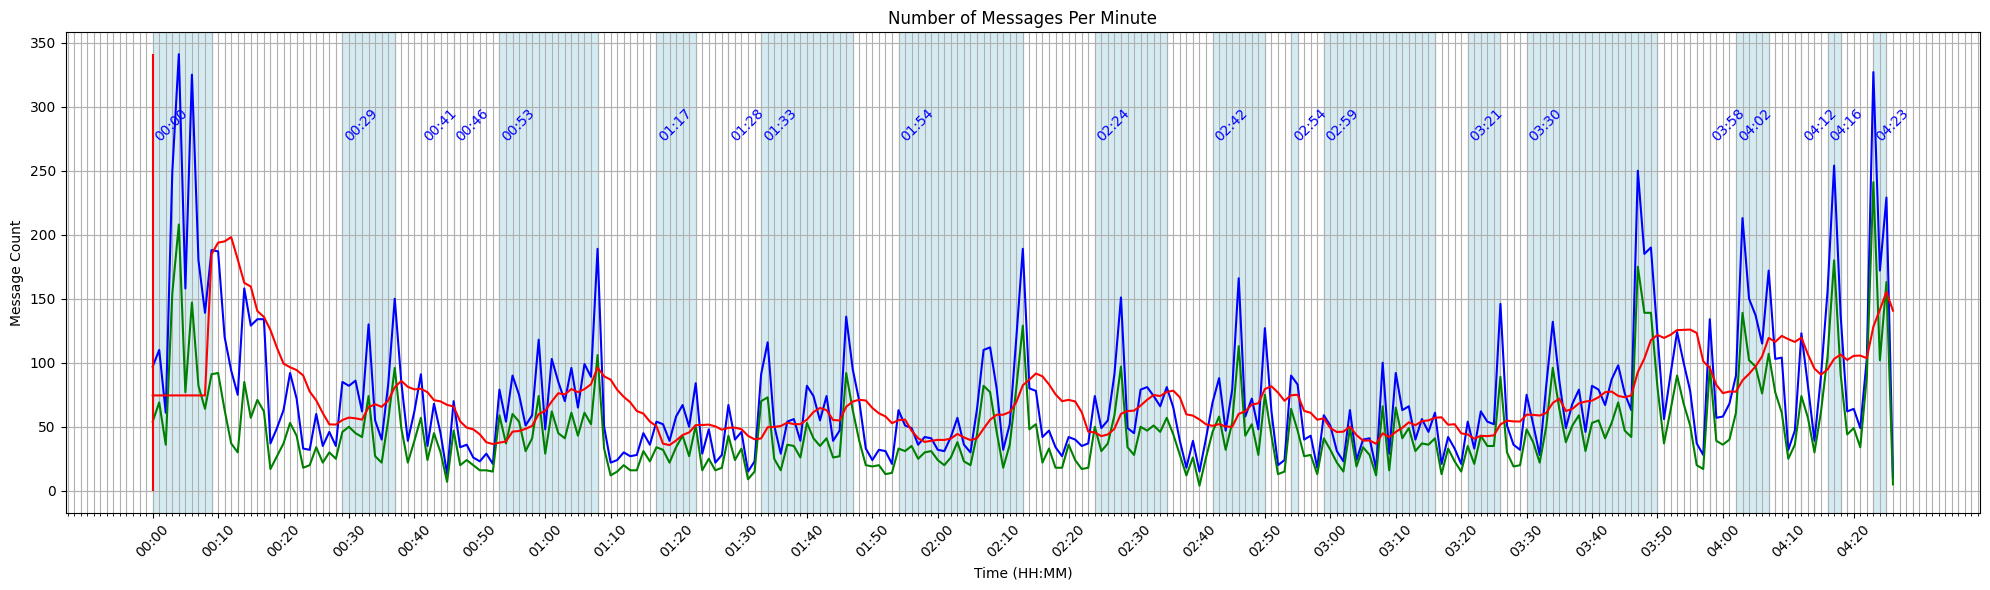

In [27]:
plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['time_in_minutes'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['time_in_minutes'], member_messages_per_minute['message_count'], label='Member Messages', color='green')

plt.plot(moving_average['time_in_minutes'], moving_average['message_count'], label="Moving Average", color='red')

for start, end in merged_intervals:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, total_messages_per_minute['message_count'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.savefig(env_.chat_timeline_path)
plt.show()

In [28]:
# from stream_analysis.summary import Summary

# df_filtered = df[df['cleaned_message'].str.len() > 0]

# summary = Summary(env_, '\n'.join(df_filtered[['message']].to_numpy().flatten())).getContent()
# summary

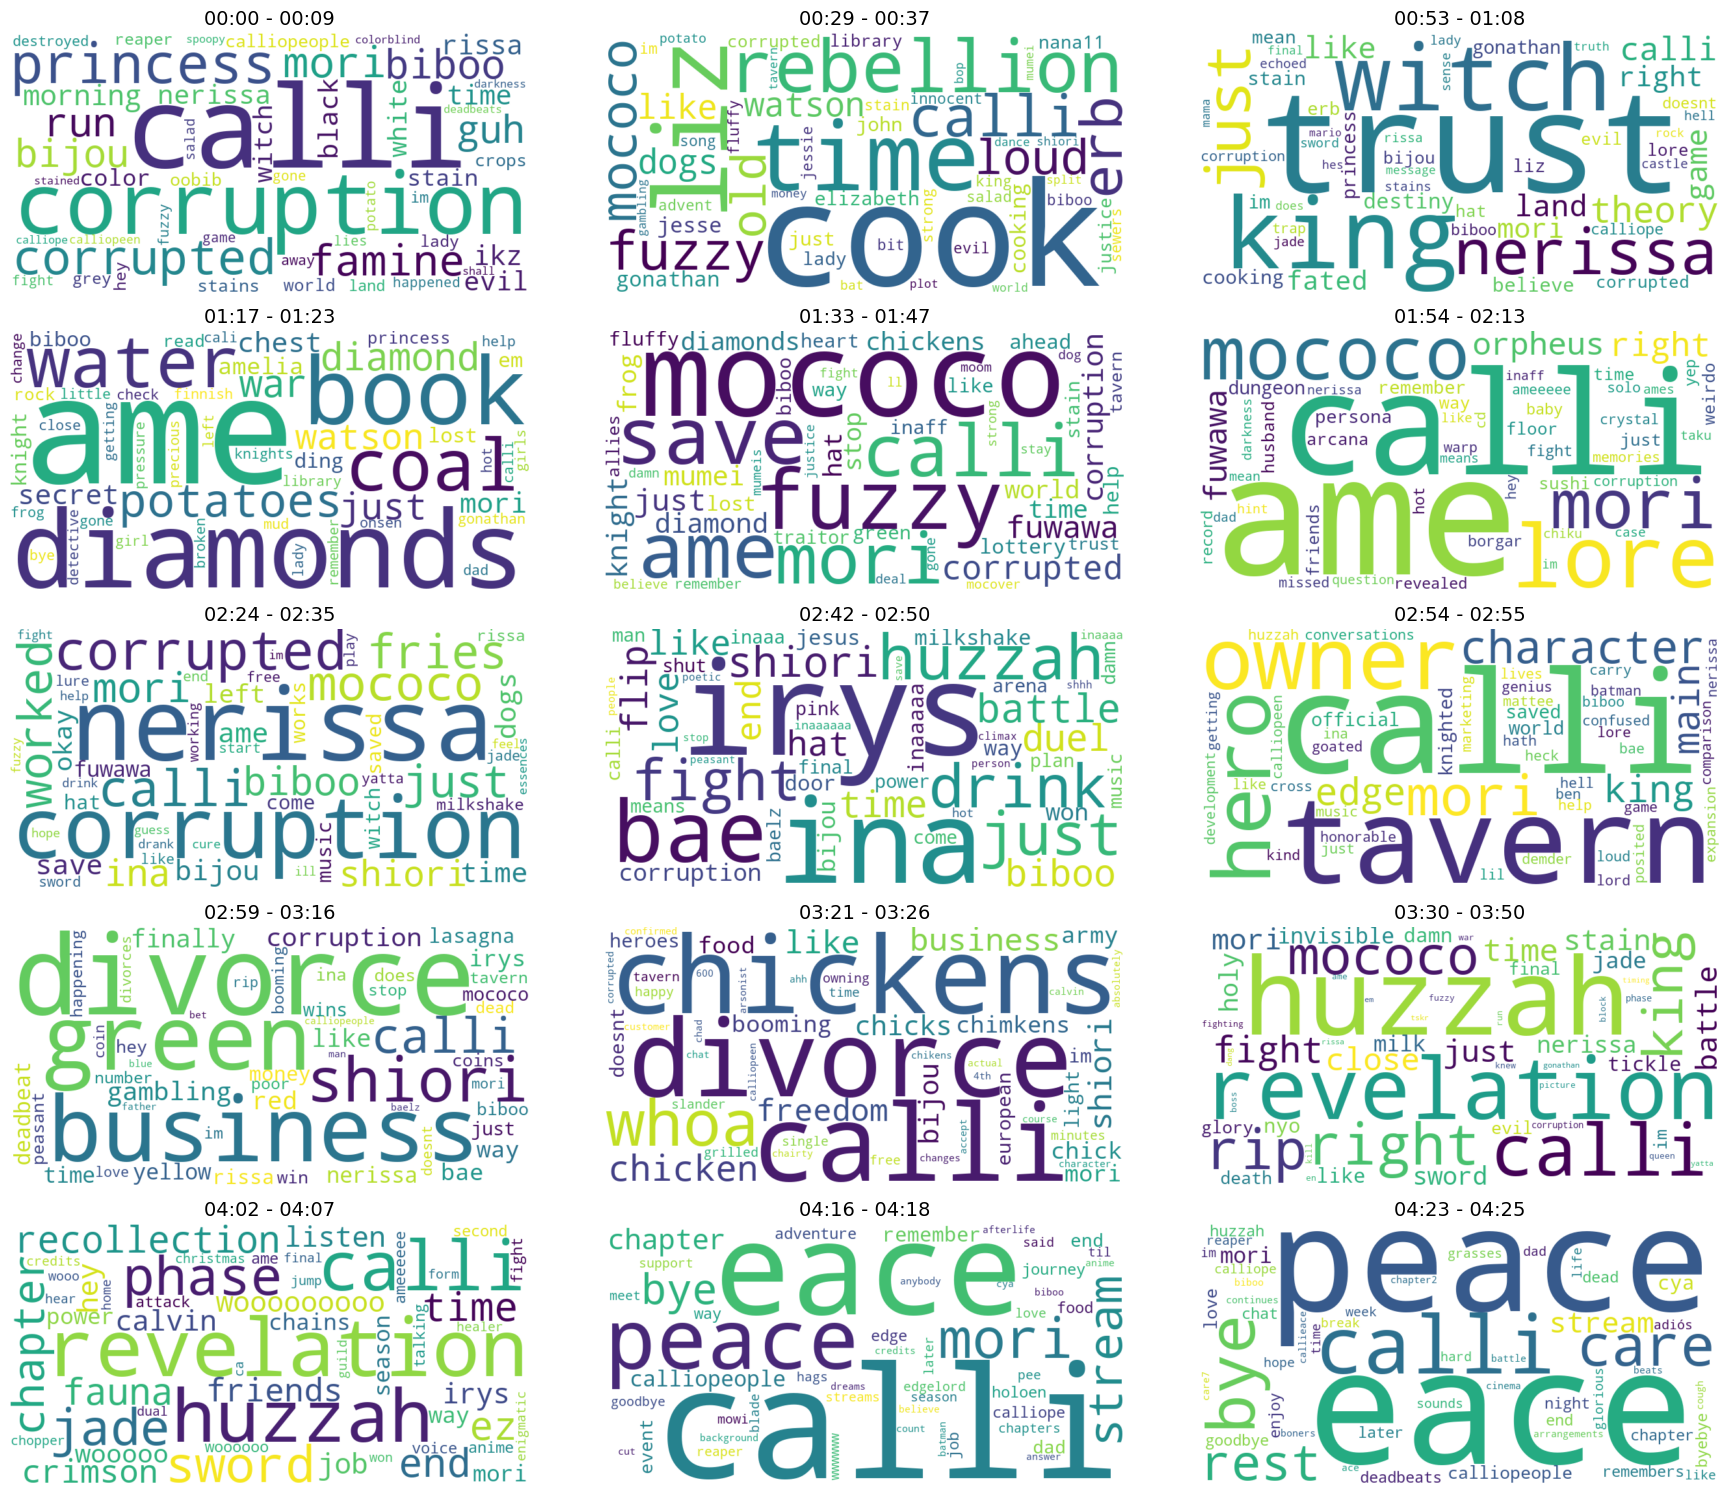

In [29]:
num_intervals = len(merged_intervals)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

index = -1
for i, time_range in enumerate(merged_intervals):
    try:
        index += 1
        start = time_range[0] * 60
        end = time_range[1] * 60
        start_label = minutes_to_hhmm(time_range[0])
        end_label = minutes_to_hhmm(time_range[1])

        df_filtered = df[(df['time_in_seconds'] >= start) & (df['time_in_seconds'] <= end) & (df['cleaned_message'].str.len() > 0)]

        word_freq = get_word_freq(df_filtered['cleaned_message'])
        word_path = os.path.join(env_.data_path, f'{start_label}_{end_label}'.replace(':', '-'))
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3).generate_from_frequencies(word_freq)

        df_filtered[['time_in_seconds', 'message']].to_csv(f'{word_path}_chat.csv', encoding='utf8', index=False)
        word_freq.to_csv(f'{word_path}_wfreq.csv', encoding='utf8', header=False)

        ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

        ax.set_title(f'{start_label} - {end_label}', fontsize=14)
    except Exception as e:
        index -= 1
        continue

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.savefig(env_.chat_wordcloud_path)
plt.show()

In [30]:
font_name = os.getenv('DEFAULT_FONT_NAME')
font_path = f"{os.getenv('DEFAULT_FONT_PATH')}/{font_name}/{os.getenv('DEFAULT_FONT_FILENAME')}"
pdfmetrics.registerFont(TTFont(font_name, font_path, 'utf8'))

c = canvas.Canvas(os.path.join(env_.data_path, 'report.pdf'), pagesize=A4)

width, height = A4
cursor = height
margin = 8
available_width = width - 2 * margin

c.setFont(font_name, 16)

cursor = height - 32

text_width = c.stringWidth(env_.video_title)
x_position = (available_width - text_width) / 2  # 計算置中位置

c.drawString(x_position, cursor, env_.video_title)

c.setFont(font_name, 12)
cursor = cursor - 17
text_width = c.stringWidth(env_.video_liver)
x_position = (available_width - text_width)
c.drawString(x_position, cursor, env_.video_liver)

# cursor = cursor - 10
# cursor = draw_markdown_to_pdf(c, summary, cursor, margin, width, height, font_name)

image = ImageReader(env_.chat_timeline_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

image = ImageReader(env_.chat_wordcloud_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

c.setFont(font_name, 12)
with open(os.path.join(env_.data_path, 'watching_urls.log'), 'r', encoding='utf8') as f:
    for url in f.readlines():
        cursor = y_position = cursor - 20

        # 繪製連結文字
        c.drawString(x_position, y_position, url.strip())

        # 為該文字添加 URL
        # 計算文字寬度，確定連結區域
        text_width = c.stringWidth(url, font_name, 12)
        c.linkURL(url.strip(), (x_position, y_position, x_position + text_width, y_position + 12))

c.save()
